In [17]:
import kagglehub

path = kagglehub.dataset_download("mimdim/processed-rice-varieties-of-bangladesh")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/processed-rice-varieties-of-bangladesh


Aush: Attempting RGBe to RGB conversion.
BR-28: Attempting RGBe to RGB conversion.
BR-29: Attempting RGBe to RGB conversion.
Beroi: Attempting RGBe to RGB conversion.
Chinigura: Attempting RGBe to RGB conversion.
Ghee Bhog: Attempting RGBe to RGB conversion.
Katari Najir: Attempting RGBe to RGB conversion.
Katari Siddho: Attempting RGBe to RGB conversion.
Miniket: Attempting RGBe to RGB conversion.
Swarna: Attempting RGBe to RGB conversion.


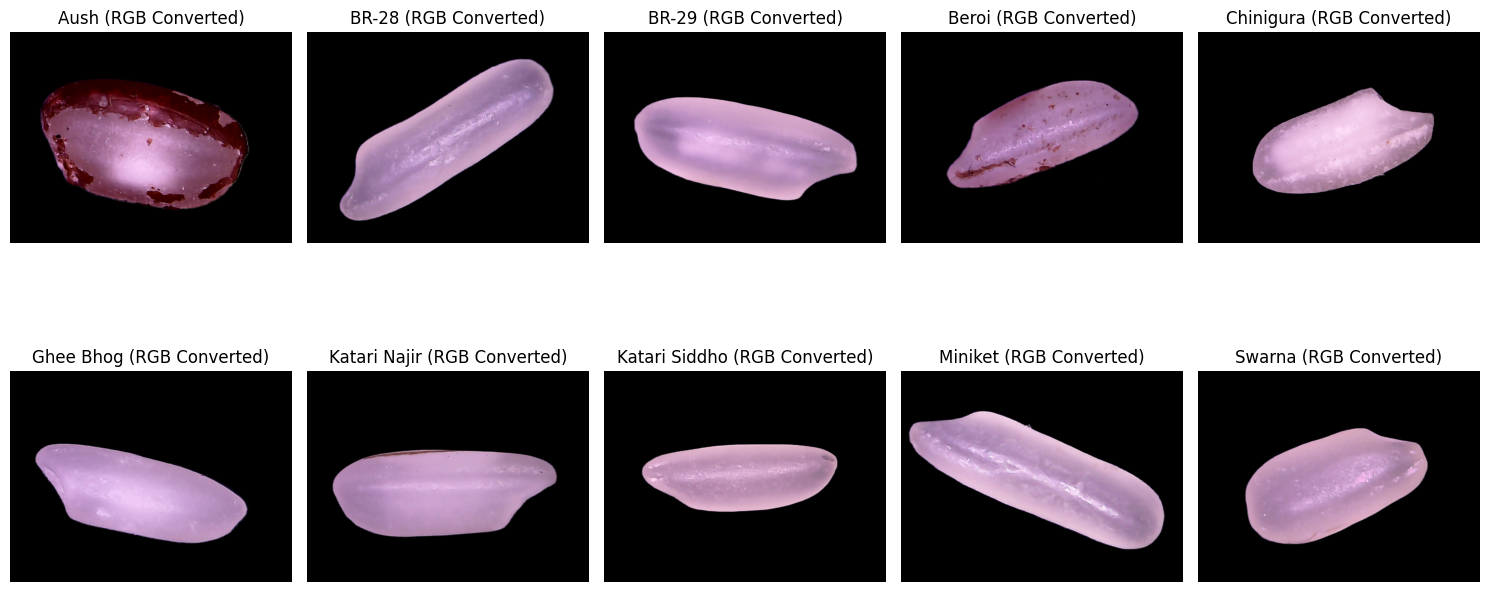

In [18]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# ---------- Function: RGBe → RGB (smooth, non-binary) ----------
def rgbe_to_rgb(img):
    """Converts a 4-channel RGBe image to smooth RGB (0-255)."""
    if img is None or img.ndim != 3 or img.shape[2] != 4:
        print("Warning: Input is not a valid 4-channel image for RGBe conversion.")
        return None

    r, g, b, e = cv2.split(img.astype(np.float32))
    scale = np.exp2(e - 128.0)
    rgb = np.stack([(r / 255) * scale, (g / 255) * scale, (b / 255) * scale], axis=-1)

    # Normalize to 0-255 without binary mapping
    rgb_min, rgb_max = rgb.min(), rgb.max()
    if rgb_max - rgb_min > 0:
        rgb = (rgb - rgb_min) / (rgb_max - rgb_min)
    else:
        rgb = np.zeros_like(rgb)
    rgb = (rgb * 255).astype(np.uint8)

    return rgb

# ---------- Folder paths ----------
dataset_dir = "/kaggle/input/processed-rice-varieties-of-bangladesh/PRBD Microscopic Image of Different Processed Rice/Original_Images"

if not os.path.exists(dataset_dir):
    print(f"Error: Dataset directory not found at {dataset_dir}. Please ensure the dataset is downloaded and extracted correctly.")
else:
    classes = sorted(os.listdir(dataset_dir))

    plt.figure(figsize=(15, 8))

    for i, cls in enumerate(classes):
        class_path = os.path.join(dataset_dir, cls)

        if not os.path.isdir(class_path):
            print(f"Skipping {cls}: Not a directory.")
            continue

        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if not image_files:
            print(f"{cls}: No image files found, skipping.")
            continue

        img_path = os.path.join(class_path, image_files[0])
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

        img_to_display = None
        title_text = cls

        if img is not None and isinstance(img, np.ndarray):
            if img.ndim == 3:  # Color images
                if img.shape[2] == 4:  # RGBe
                    print(f"{cls}: Attempting RGBe to RGB conversion.")
                    img_rgb = rgbe_to_rgb(img)
                    if img_rgb is not None:
                        img_to_display = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
                        title_text += " (RGB Converted)"
                    else:
                        print(f"{cls}: Failed RGBe to RGB conversion.")
                elif img.shape[2] == 3:  # Normal RGB
                    print(f"{cls}: Normal RGB image, using directly.")
                    img_to_display = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)
                    title_text += " (Original RGB)"
                else:
                    print(f"{cls}: Unsupported number of channels ({img.shape[2]}), skipping.")
            elif img.ndim == 2:  # Grayscale
                print(f"{cls}: Grayscale image, skipping for visualization.")
            else:
                print(f"{cls}: Unsupported number of dimensions ({img.ndim}), skipping.")
        else:
            print(f"{cls}: Could not load image at {img_path} or it is not a valid numpy array, skipping.")

        # Plotting
        plt.subplot(2, (len(classes) + 1) // 2, i + 1)
        if img_to_display is not None:
            plt.imshow(img_to_display)
            plt.title(title_text)
        else:
            plt.text(0.5, 0.5, "Image Skipped", horizontalalignment='center', verticalalignment='center')
            plt.title(title_text + " (Skipped)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [19]:
import os
import shutil
import numpy as np

# -----------------------------
# Paths
# -----------------------------
dataset_dir = "/kaggle/input/processed-rice-varieties-of-bangladesh/PRBD Microscopic Image of Different Processed Rice/Original_Images"
split_base_dir = '/kaggle/working/split_data'

# -----------------------------
# Prepare directories
# -----------------------------
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
splits = ['train', 'val', 'test']

# Clear previous split (optional)
if os.path.exists(split_base_dir):
    shutil.rmtree(split_base_dir)

for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(split_base_dir, split, cls), exist_ok=True)

# -----------------------------
# Perform split
# -----------------------------
for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    images = sorted(os.listdir(class_dir))
    np.random.shuffle(images)

    total = len(images)

    # Step 1: 50:50 train:test
    train_val_end = int(total * 0.5)
    train_val_images = images[:train_val_end]
    test_images = images[train_val_end:]

    # Step 2: Within training portion, 10% for validation
    val_end = int(len(train_val_images) * 0.1)
    val_images = train_val_images[:val_end]
    train_images = train_val_images[val_end:]

    # Mapping
    split_images = {
        'train': train_images,
        'val': val_images,
        'test': test_images
    }

    # Copy images
    for split in splits:
        for img_name in split_images[split]:
            src = os.path.join(class_dir, img_name)
            dst = os.path.join(split_base_dir, split, cls, img_name)
            shutil.copy(src, dst)

# -----------------------------
# Print split summary
# -----------------------------
print("Dataset Split Summary (number of images per class):\n")
for split in splits:
    print(f"--- {split.upper()} ---")
    for cls in classes:
        split_cls_dir = os.path.join(split_base_dir, split, cls)
        count = len(os.listdir(split_cls_dir))
        print(f"{cls}: {count}")
    print()


Dataset Split Summary (number of images per class):

--- TRAIN ---
Swarna: 90
Katari Siddho: 90
Beroi: 90
BR-29: 90
Katari Najir: 90
Miniket: 90
Chinigura: 90
Ghee Bhog: 90
BR-28: 90
Aush: 90

--- VAL ---
Swarna: 10
Katari Siddho: 10
Beroi: 10
BR-29: 10
Katari Najir: 10
Miniket: 10
Chinigura: 10
Ghee Bhog: 10
BR-28: 10
Aush: 10

--- TEST ---
Swarna: 100
Katari Siddho: 100
Beroi: 100
BR-29: 100
Katari Najir: 100
Miniket: 100
Chinigura: 100
Ghee Bhog: 100
BR-28: 100
Aush: 100



Found 900 images belonging to 10 classes.
Found 100 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Epoch 1/50
29/29 - 78s - 3s/step - accuracy: 0.4778 - loss: 1.5663 - val_accuracy: 0.7200 - val_loss: 0.9096 - learning_rate: 0.0010
Epoch 2/50
29/29 - 7s - 253ms/step - accuracy: 0.7611 - loss: 0.7890 - val_accuracy: 0.7900 - val_loss: 0.7018 - learning_rate: 0.0010
Epoch 3/50
29/29 - 7s - 252ms/step - accuracy: 0.7844 - loss: 0.6807 - val_accuracy: 0.7500 - val_loss: 0.7224 - learning_rate: 0.0010
Epoch 4/50
29/29 - 7s - 248ms/step - accuracy: 0.8067 - loss: 0.5950 - val_accuracy: 0.7900 - val_loss: 0.6395 - learning_rate: 0.0010
Epoch 5/50
29/29 - 7s - 252ms/step - accuracy: 0.8567 - loss: 0.4982 - val_accuracy: 0.8400 - val_loss: 0.5650 - learning_rate: 0.0010
Epoch 6/50
29/29 - 7s - 253ms/step - accuracy: 0.8511 - loss: 0.4611 - val_accuracy: 0.8200 - val_loss: 0.5877 - learning_rate: 0.0010
Epoch 7/50
29/29 - 7s - 250ms/step - accuracy: 0.8856 - loss: 0.4

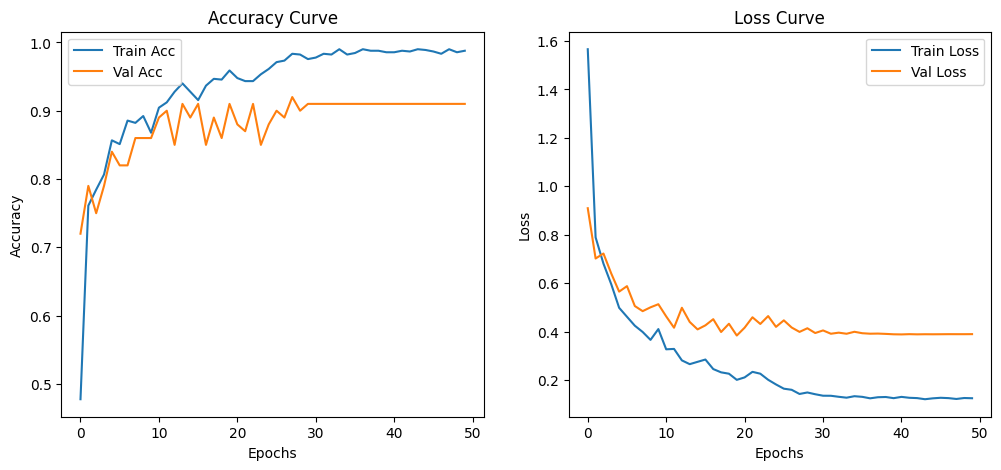


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.9800    0.9800    0.9800       100
Katari Siddho     0.7979    0.7500    0.7732       100
        Beroi     0.7818    0.8600    0.8190       100
        BR-29     1.0000    0.9800    0.9899       100
 Katari Najir     0.9346    1.0000    0.9662       100
      Miniket     0.8526    0.8100    0.8308       100
    Chinigura     0.8211    0.7800    0.8000       100
    Ghee Bhog     0.8384    0.8300    0.8342       100
        BR-28     0.9787    0.9200    0.9485       100
         Aush     0.8426    0.9100    0.8750       100

     accuracy                         0.8820      1000
    macro avg     0.8828    0.8820    0.8817      1000
 weighted avg     0.8828    0.8820    0.8817      1000



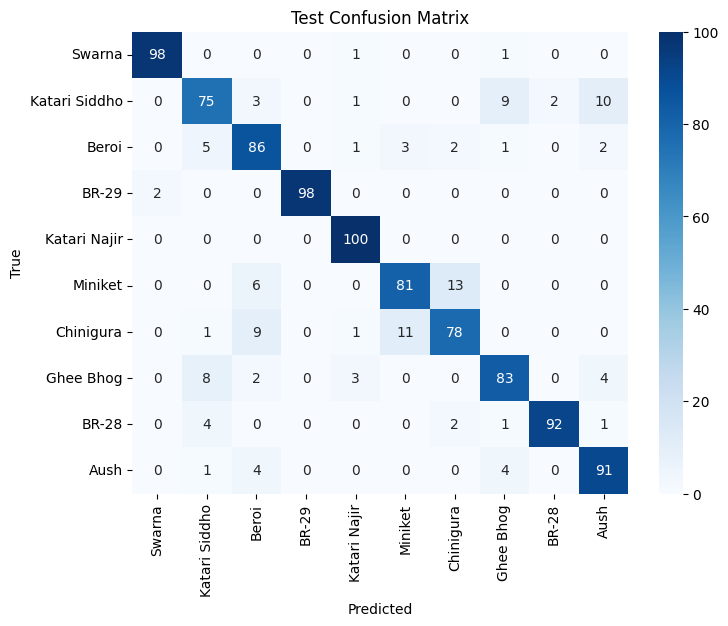

Swarna Accuracy: 0.9800
Katari Siddho Accuracy: 0.7500
Beroi Accuracy: 0.8600
BR-29 Accuracy: 0.9800
Katari Najir Accuracy: 1.0000
Miniket Accuracy: 0.8100
Chinigura Accuracy: 0.7800
Ghee Bhog Accuracy: 0.8300
BR-28 Accuracy: 0.9200
Aush Accuracy: 0.9100
Test AUC: 0.9911
Test PR AUC: 0.9382

Training Time: 435.32 seconds


In [20]:
#Model: NASNetMobile

import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data'
img_size = (224, 224)
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators
# -----------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Model: NASNetMobile
# -----------------------------
def build_nasnetmobile_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = NASNetMobile(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

nasnet_model = build_nasnetmobile_model(num_classes=num_classes)
nasnet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# Callback (only LR scheduler, no early stop)
# -----------------------------
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training (50 epochs, no early stop)
# -----------------------------
start_time = time.time()
history = nasnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[reduce_lr],
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, nasnet_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, nasnet_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, nasnet_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# AUC & PR
print(f"Test AUC: {roc_auc_score(test_true_prob, test_pred_prob, average='macro', multi_class='ovr'):.4f}")
print(f"Test PR AUC: {average_precision_score(test_true_prob, test_pred_prob, average='macro'):.4f}")

print(f"\nTraining Time: {training_time:.2f} seconds")


Macro Precision: 0.8828
Macro Recall: 0.8820
Macro F1-score: 0.8817
Swarna: Precision=0.9800, Recall=0.9800, F1=0.9800
Katari Siddho: Precision=0.7979, Recall=0.7500, F1=0.7732
Beroi: Precision=0.7818, Recall=0.8600, F1=0.8190
BR-29: Precision=1.0000, Recall=0.9800, F1=0.9899
Katari Najir: Precision=0.9346, Recall=1.0000, F1=0.9662
Miniket: Precision=0.8526, Recall=0.8100, F1=0.8308
Chinigura: Precision=0.8211, Recall=0.7800, F1=0.8000
Ghee Bhog: Precision=0.8384, Recall=0.8300, F1=0.8342
BR-28: Precision=0.9787, Recall=0.9200, F1=0.9485
Aush: Precision=0.8426, Recall=0.9100, F1=0.8750


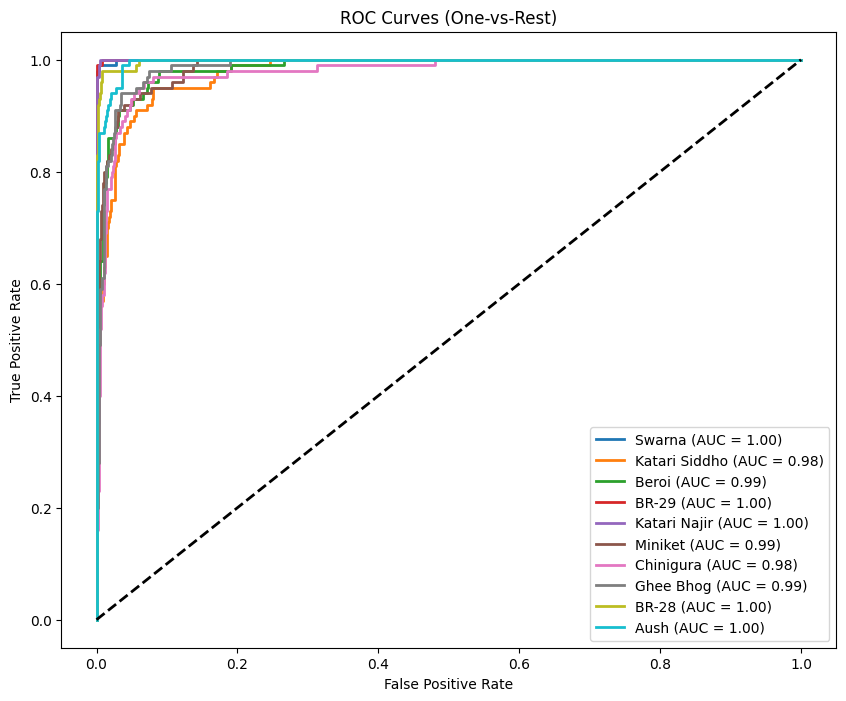

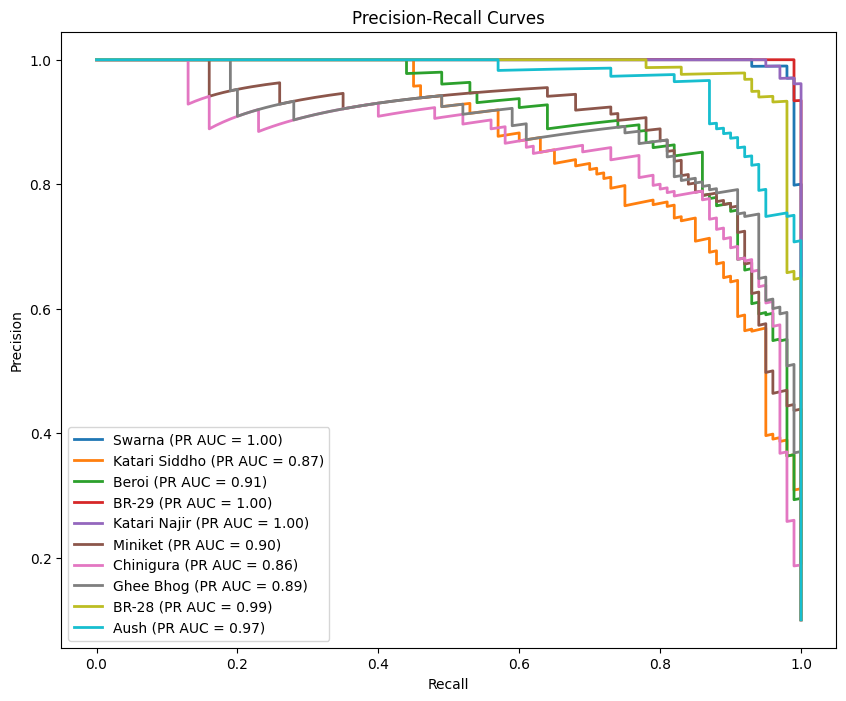

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Total inference time: 34.60 sec
Inference time per sample: 0.034598 sec

Most confused class pairs:
Swarna is most often confused with Katari Najir (1 samples)
Katari Siddho is most often confused with Aush (10 samples)
Beroi is most often confused with Katari Siddho (5 samples)
BR-29 is most often confused with Swarna (2 samples)
Katari Najir is most often confused with Swarna (0 samples)
Miniket is most often confused with Chinigura (13 samples)
Chinigura is most often confused with Miniket (11 samples)
Ghee Bhog is most often confused with Katari Siddho (8 samples)
BR-28 is most often confused with Katari Siddho (4 samples)
Aush is most often confused with Beroi (4 samples)


In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, average_precision_score, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import time
import matplotlib.pyplot as plt

# -----------------------------
# Precision, Recall, F1-score
# -----------------------------
macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# Per-class scores
per_class_precision = precision_score(test_true, test_pred, average=None)
per_class_recall = recall_score(test_true, test_pred, average=None)
per_class_f1 = f1_score(test_true, test_pred, average=None)

for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# PR curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Testing / Inference time per sample
# -----------------------------
start_infer = time.time()
_ = nasnet_model.predict(test_gen, verbose=0)
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")

# -----------------------------
# Failure modes: most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0  # ignore correct predictions
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")

In [22]:
start_test = time.time()
_ = nasnet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")


Inference Time per sample: 0.007593 seconds


In [23]:
# Calculate and print the number of parameters
total_params = nasnet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 4,816,030
Trainable Parameters: 546,314
Non-Trainable Parameters: 4,269,716


Found 810 images belonging to 10 classes.
Found 90 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
26/26 - 42s - 2s/step - accuracy: 0.3827 - loss: 1.8528 - val_accuracy: 0.6778 - val_loss: 1.2567 - learning_rate: 0.0010
Epoch 2/50
26/26 - 16s - 624ms/step - accuracy: 0.6062 - loss: 1.1771 - val_accuracy: 0.7000 - val_loss: 1.0735 - learning_rate: 0.0010
Epoch 3/50
26/26 - 16s - 605ms/step - accuracy: 0.7272 - loss: 0.8968 - val_accuracy: 0.6889 - val_loss: 0.8854 - learning_rate: 0.0010
Epoch 4/50
26/26 - 16s - 620ms/step - accuracy: 0.7235 - loss: 0.8264 - val_accuracy: 0.7222 - val_loss: 0.8067 - learning_rate: 0.0010
Epoch 5/50
26/26 - 16s - 627ms/step - accuracy: 0.7765 - loss: 0.7060 - val_accuracy: 0.7667 - val_loss: 0.7171 - learning_rate: 0.0010
Epoch 6/50
26/26 - 16s - 617ms/step - accuracy: 0.8185 - loss: 0.6323 - val_accuracy: 0.7889 - val_loss: 0.6585 - learning_rate: 0.0010
Epoch 7/50
26/26 - 16s - 601ms/step - accuracy: 0.8222 - loss: 0.5811 - val_accuracy: 0.7333 - val_loss: 0.7011 - learning_rate: 0.0010
Epoch 8/50
26/26 - 16s - 622ms/step - accuracy: 0.8

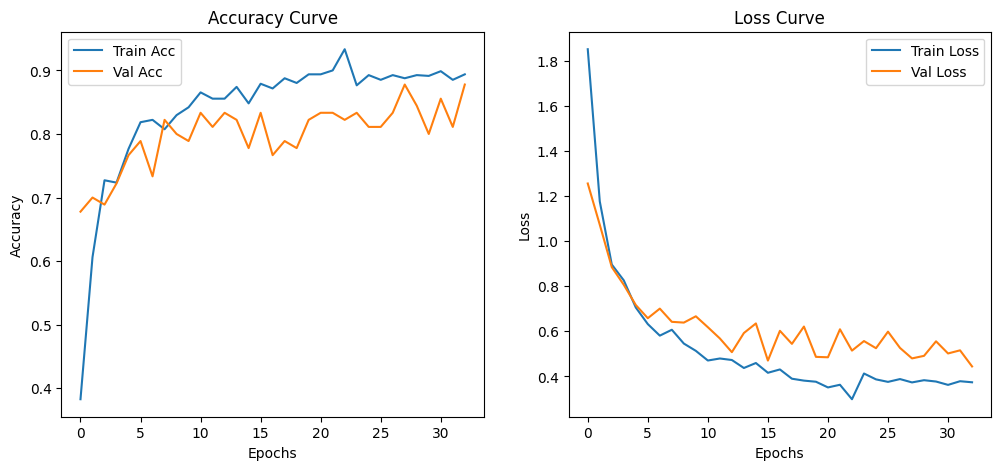


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.9899    0.9800    0.9849       100
Katari Siddho     0.6429    0.9000    0.7500       100
        Beroi     0.8200    0.8200    0.8200       100
        BR-29     0.9898    0.9700    0.9798       100
 Katari Najir     0.9901    1.0000    0.9950       100
      Miniket     0.7600    0.9500    0.8444       100
    Chinigura     0.9818    0.5400    0.6968       100
    Ghee Bhog     0.8230    0.9300    0.8732       100
        BR-28     1.0000    0.8100    0.8950       100
         Aush     0.9091    0.8000    0.8511       100

     accuracy                         0.8700      1000
    macro avg     0.8907    0.8700    0.8690      1000
 weighted avg     0.8907    0.8700    0.8690      1000



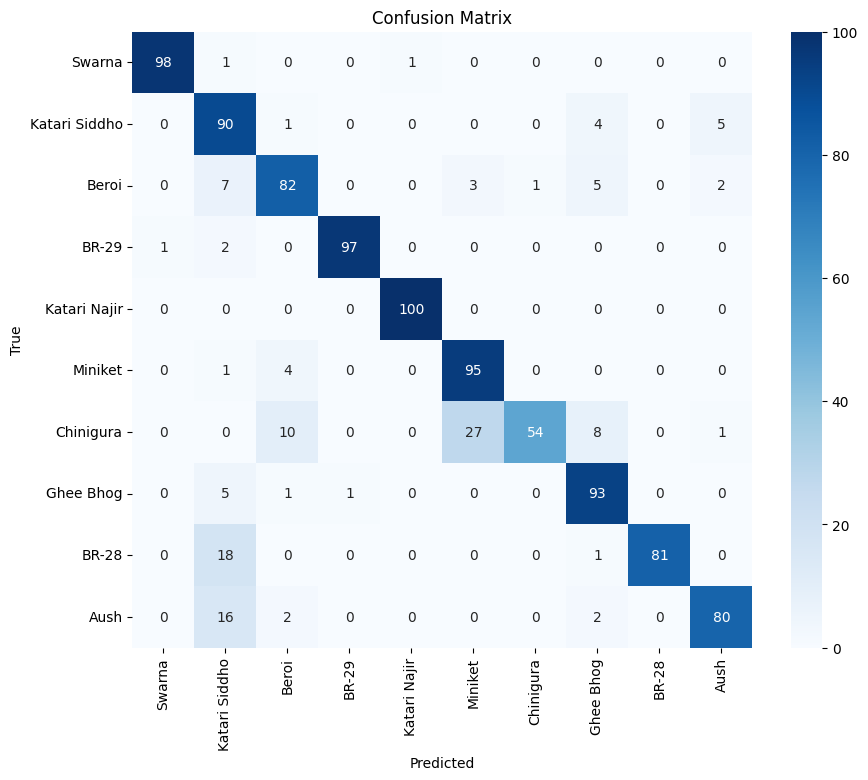

Swarna Accuracy: 0.9800
Katari Siddho Accuracy: 0.9000
Beroi Accuracy: 0.8200
BR-29 Accuracy: 0.9700
Katari Najir Accuracy: 1.0000
Miniket Accuracy: 0.9500
Chinigura Accuracy: 0.5400
Ghee Bhog Accuracy: 0.9300
BR-28 Accuracy: 0.8100
Aush Accuracy: 0.8000
Test AUC: 0.9934
Test PR AUC: 0.9534

Total Training Time: 391.88 seconds


In [24]:
#Model-2: ConvNeXtTiny
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.applications.convnext import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Paths and parameters
# -----------------------------
dataset_dir = "/kaggle/input/processed-rice-varieties-of-bangladesh/PRBD Microscopic Image of Different Processed Rice/Original_Images"
split_base_dir = '/kaggle/working/split_data'
img_size = (224, 224)
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data Generators with Augmentation
# -----------------------------
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    validation_split=0.1  # 10% validation from 20% train+val
)

train_gen = train_datagen.flow_from_directory(
    split_base_dir+'/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    split_base_dir+'/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = test_datagen.flow_from_directory(
    split_base_dir+'/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Compute class weights
# -----------------------------
train_labels = train_gen.classes
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

# -----------------------------
# Build ConvNeXtTiny model
# -----------------------------
def build_convnext_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = ConvNeXtTiny(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze backbone initially
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

convnext_model = build_convnext_model(num_classes=num_classes)
convnext_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -----------------------------
# Callbacks
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint('best_convnext_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

# -----------------------------
# Training (Frozen backbone) - 50 epochs
# -----------------------------
start_time = time.time()
history = convnext_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,   # 50 epochs frozen
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Fine-tuning (last 20 layers)
# -----------------------------
convnext_model.trainable = True
for layer in convnext_model.layers[:-20]:
    layer.trainable = False

convnext_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_ft = convnext_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,   # fine-tuning for 10 epochs
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=2
)

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'] + history_ft.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'] + history_ft.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'] + history_ft.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, convnext_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, convnext_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, convnext_model)

print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

print(f"Test AUC: {roc_auc_score(test_true_prob, test_pred_prob, average='macro', multi_class='ovr'):.4f}")
print(f"Test PR AUC: {average_precision_score(test_true_prob, test_pred_prob, average='macro'):.4f}")

print(f"\nTotal Training Time: {training_time:.2f} seconds")


Macro Precision: 0.8907
Macro Recall: 0.8700
Macro F1-score: 0.8690
Swarna: Precision=0.9899, Recall=0.9800, F1=0.9849
Katari Siddho: Precision=0.6429, Recall=0.9000, F1=0.7500
Beroi: Precision=0.8200, Recall=0.8200, F1=0.8200
BR-29: Precision=0.9898, Recall=0.9700, F1=0.9798
Katari Najir: Precision=0.9901, Recall=1.0000, F1=0.9950
Miniket: Precision=0.7600, Recall=0.9500, F1=0.8444
Chinigura: Precision=0.9818, Recall=0.5400, F1=0.6968
Ghee Bhog: Precision=0.8230, Recall=0.9300, F1=0.8732
BR-28: Precision=1.0000, Recall=0.8100, F1=0.8950
Aush: Precision=0.9091, Recall=0.8000, F1=0.8511


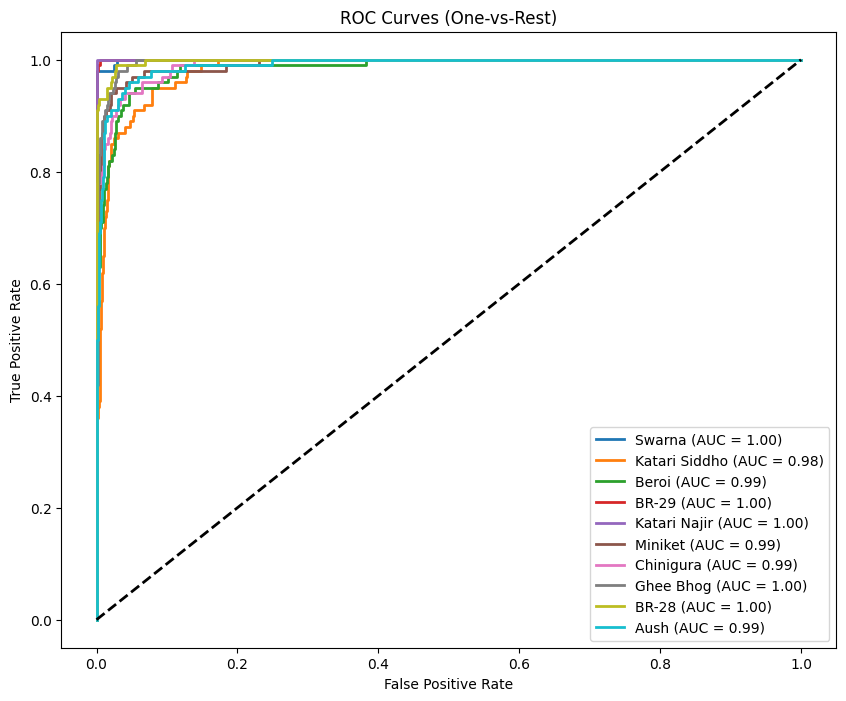

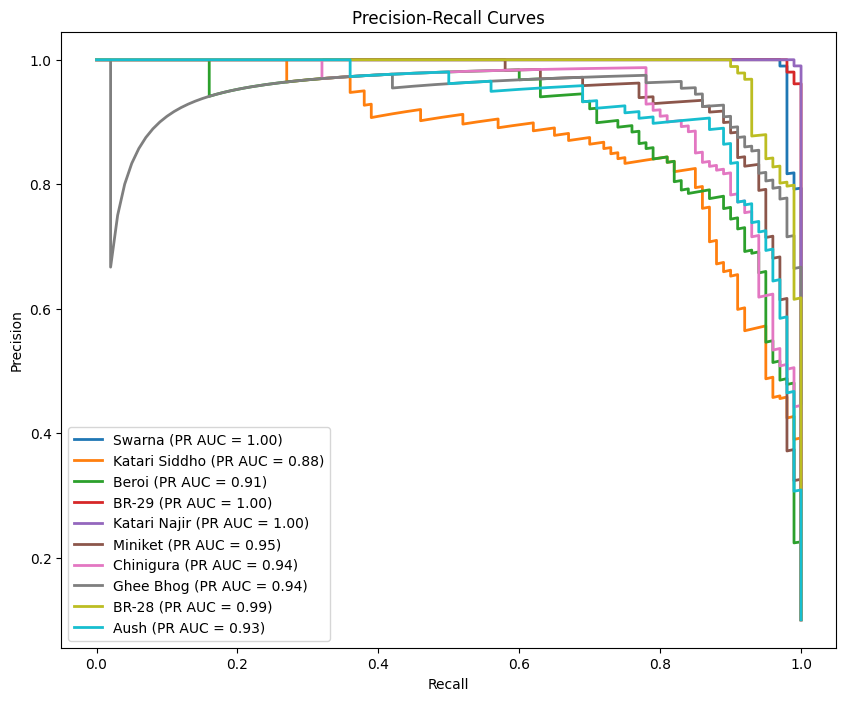


Most confused class pairs:
Swarna is most often confused with Katari Siddho (1 samples)
Katari Siddho is most often confused with Aush (5 samples)
Beroi is most often confused with Katari Siddho (7 samples)
BR-29 is most often confused with Katari Siddho (2 samples)
Katari Najir is most often confused with Swarna (0 samples)
Miniket is most often confused with Beroi (4 samples)
Chinigura is most often confused with Miniket (27 samples)
Ghee Bhog is most often confused with Katari Siddho (5 samples)
BR-28 is most often confused with Katari Siddho (18 samples)
Aush is most often confused with Katari Siddho (16 samples)


In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, average_precision_score, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import time
import matplotlib.pyplot as plt

# -----------------------------
# Precision, Recall, F1-score
# -----------------------------
macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# Per-class scores
per_class_precision = precision_score(test_true, test_pred, average=None)
per_class_recall = recall_score(test_true, test_pred, average=None)
per_class_f1 = f1_score(test_true, test_pred, average=None)

for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# PR curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# Failure modes: most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0  # ignore correct predictions
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [26]:
start_test = time.time()
_ = convnext_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Inference Time per sample: 0.013916 seconds


In [27]:
# Calculate and print the number of parameters
total_params = convnext_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 28,218,986
Trainable Parameters: 546,314
Non-Trainable Parameters: 4,269,716


Found 900 images belonging to 10 classes.
Found 100 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Epoch 1/50
29/29 - 52s - 2s/step - accuracy: 0.5022 - loss: 1.5871 - val_accuracy: 0.7800 - val_loss: 0.7185 - learning_rate: 0.0010
Epoch 2/50
29/29 - 25s - 865ms/step - accuracy: 0.6800 - loss: 0.9482 - val_accuracy: 0.8000 - val_loss: 0.6821 - learning_rate: 0.0010
Epoch 3/50
29/29 - 25s - 860ms/step - accuracy: 0.7111 - loss: 0.8763 - val_accuracy: 0.8200 - val_loss: 0.6111 - learning_rate: 0.0010
Epoch 4/50
29/29 - 24s - 837ms/step - accuracy: 0.7133 - loss: 0.8535 - val_accuracy: 0.8500 - val_loss: 0.4882 - learning_rate: 0.0010
Epoch 5/50
29/29 - 25s - 856ms/step - accuracy: 0.7811 - loss: 0.6625 - val_accuracy: 0.8900 - val_loss: 0.4184 - learning_rate: 0.0010
Epoch 6/50
29/29 - 25s - 857ms/step - accuracy: 0.7789 - loss: 0.6904 - val_accuracy: 0.8400 - val_loss: 0.4817 - learning_rate: 0.0010
Epoch 7/50
29/29 - 25s - 868ms/step - accuracy: 0.7956 - los

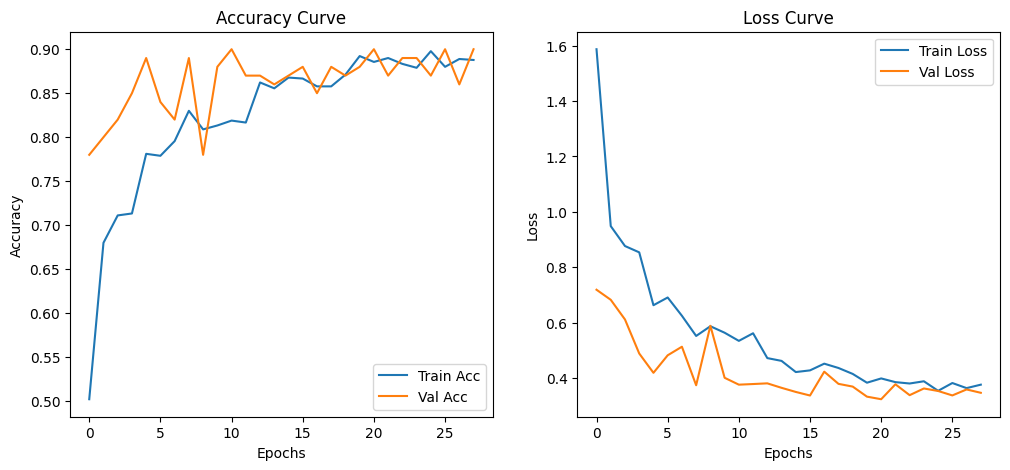


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     1.0000    0.9500    0.9744       100
Katari Siddho     0.6562    0.8400    0.7368       100
        Beroi     0.8485    0.8400    0.8442       100
        BR-29     0.9524    1.0000    0.9756       100
 Katari Najir     0.9895    0.9400    0.9641       100
      Miniket     0.7712    0.9100    0.8349       100
    Chinigura     0.8353    0.7100    0.7676       100
    Ghee Bhog     0.8077    0.8400    0.8235       100
        BR-28     0.9775    0.8700    0.9206       100
         Aush     0.9146    0.7500    0.8242       100

     accuracy                         0.8650      1000
    macro avg     0.8753    0.8650    0.8666      1000
 weighted avg     0.8753    0.8650    0.8666      1000



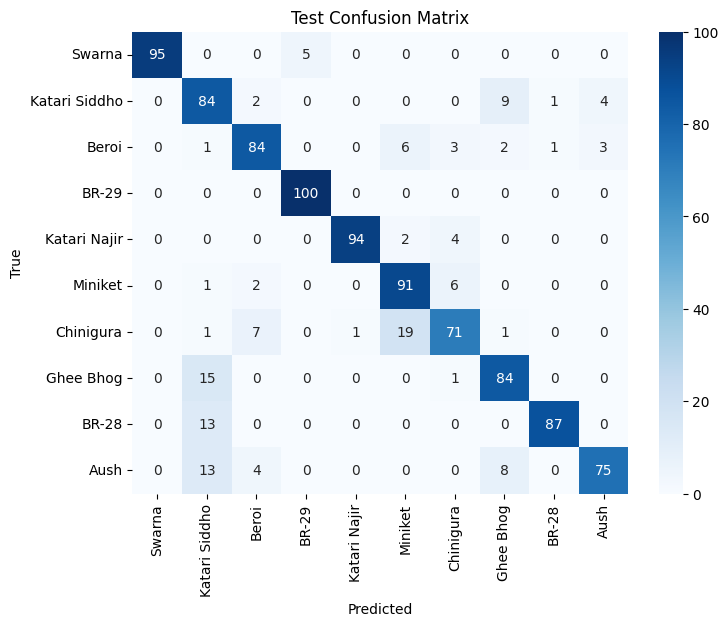

Swarna Accuracy: 0.9500
Katari Siddho Accuracy: 0.8400
Beroi Accuracy: 0.8400
BR-29 Accuracy: 1.0000
Katari Najir Accuracy: 0.9400
Miniket Accuracy: 0.9100
Chinigura Accuracy: 0.7100
Ghee Bhog Accuracy: 0.8400
BR-28 Accuracy: 0.8700
Aush Accuracy: 0.7500
Macro Precision: 0.8753, Macro Recall: 0.8650, Macro F1-score: 0.8666


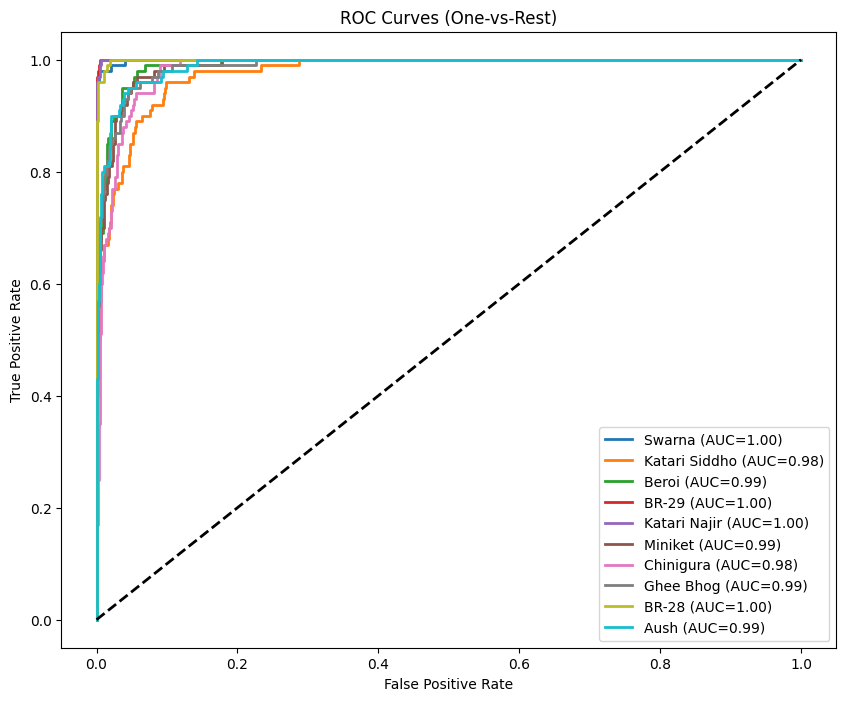

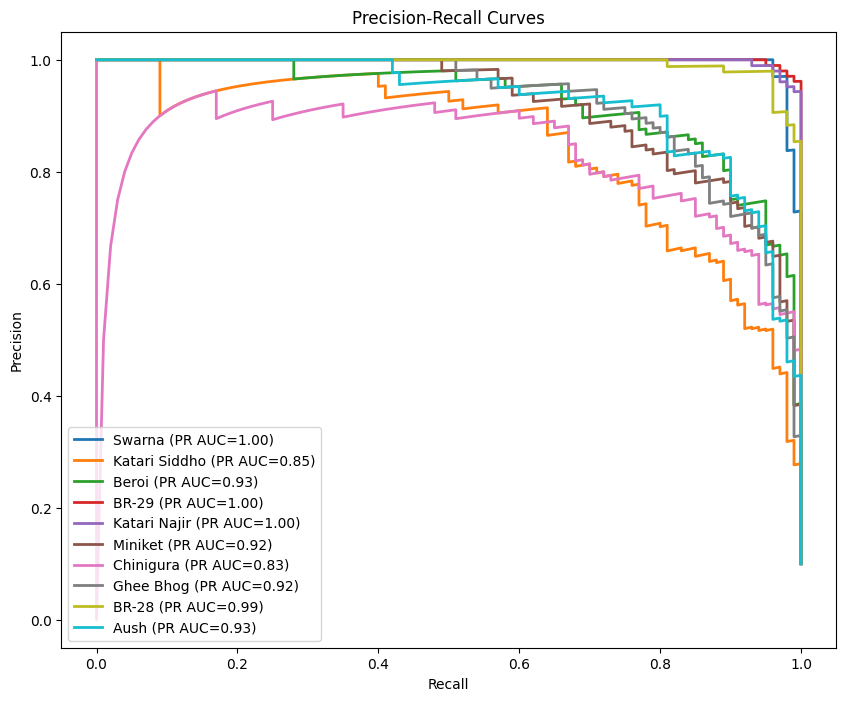


Most confused class pairs:
Swarna is most often confused with BR-29 (5 samples)
Katari Siddho is most often confused with Ghee Bhog (9 samples)
Beroi is most often confused with Miniket (6 samples)
BR-29 is most often confused with Swarna (0 samples)
Katari Najir is most often confused with Chinigura (4 samples)
Miniket is most often confused with Chinigura (6 samples)
Chinigura is most often confused with Miniket (19 samples)
Ghee Bhog is most often confused with Katari Siddho (15 samples)
BR-28 is most often confused with Katari Siddho (13 samples)
Aush is most often confused with Katari Siddho (13 samples)


In [28]:
#Model-3:InceptionV3 

import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data'
dataset_dir = "/kaggle/input/processed-rice-varieties-of-bangladesh/PRBD Microscopic Image of Different Processed Rice/Original_Images"
img_size = (299, 299)
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators with augmentation
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Build InceptionV3 model
# -----------------------------
def build_inception_model(input_shape=(299,299,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone initially
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model, base_model

model, base_model = build_inception_model(num_classes=num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -----------------------------
# Callbacks
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Train model for 50 epochs with early stopping
# -----------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, model)

# -----------------------------
# Classification report & confusion matrix
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# -----------------------------
# Per-class metrics
# -----------------------------
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')
print(f"Macro Precision: {macro_precision:.4f}, Macro Recall: {macro_recall:.4f}, Macro F1-score: {macro_f1:.4f}")

# -----------------------------
# ROC-AUC & PR Curves
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC={pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Most confused classes
# -----------------------------
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [29]:
# -----------------------------
# Inference time per sample
# -----------------------------
start_test = time.time()
_ = model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Inference Time per sample: 0.022144 seconds


In [30]:

# Model parameter summary
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")


Total Parameters: 22,857,002
Trainable Parameters: 1,054,218
Non-Trainable Parameters: 21,802,784


Found 900 images belonging to 10 classes.
Found 100 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.07000, saving model to best_resnet50_model.h5
57/57 - 53s - 937ms/step - accuracy: 0.2533 - loss: 2.1436 - val_accuracy: 0.0700 - val_loss: 2.3391 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_accuracy improved from 0.07000 to 0.35000, saving model to best_resnet50_model.h5
57/57 - 17s - 302ms/step - accuracy: 0.2822 - loss: 1.9429 - val_accuracy: 0.3500 - val_loss: 1.8612 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_accuracy did not improve from 0.35000
57/57 - 16s - 287ms/step - accuracy: 0.3300 - loss: 1.8796 - val_accuracy: 0.3300 - val_loss: 1.7907 - learning_rate: 1.0000e-04
Epoch 4/50

Epoch 4: val_accuracy improved from 0.35000 to 0.50000, saving model to best_resnet50_model.h5
57/57 - 17s - 300ms/step - accuracy: 0.3167 - loss: 1.

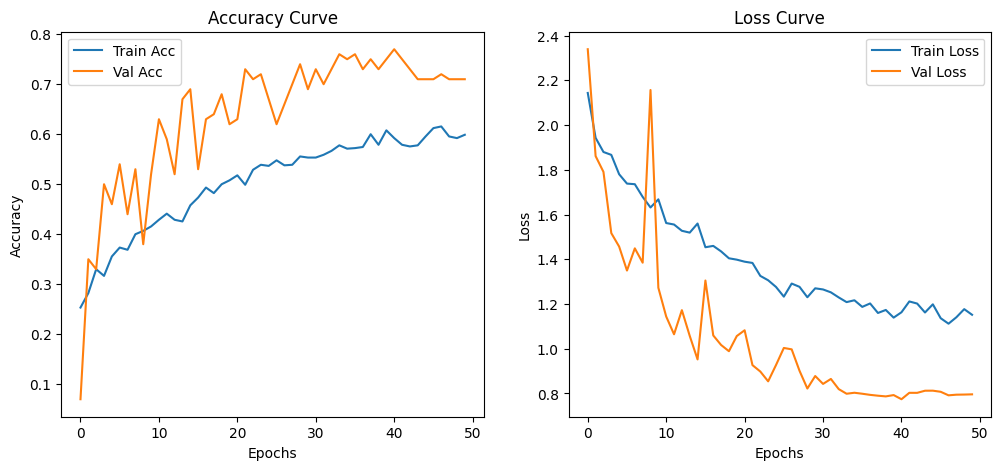


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.9231    0.9600    0.9412       100
Katari Siddho     0.6806    0.4900    0.5698       100
        Beroi     0.5156    0.6600    0.5789       100
        BR-29     0.9889    0.8900    0.9368       100
 Katari Najir     0.9286    0.5200    0.6667       100
      Miniket     0.4575    0.9700    0.6218       100
    Chinigura     0.8182    0.1800    0.2951       100
    Ghee Bhog     0.8356    0.6100    0.7052       100
        BR-28     0.8000    0.8400    0.8195       100
         Aush     0.6087    0.8400    0.7059       100

     accuracy                         0.6960      1000
    macro avg     0.7557    0.6960    0.6841      1000
 weighted avg     0.7557    0.6960    0.6841      1000



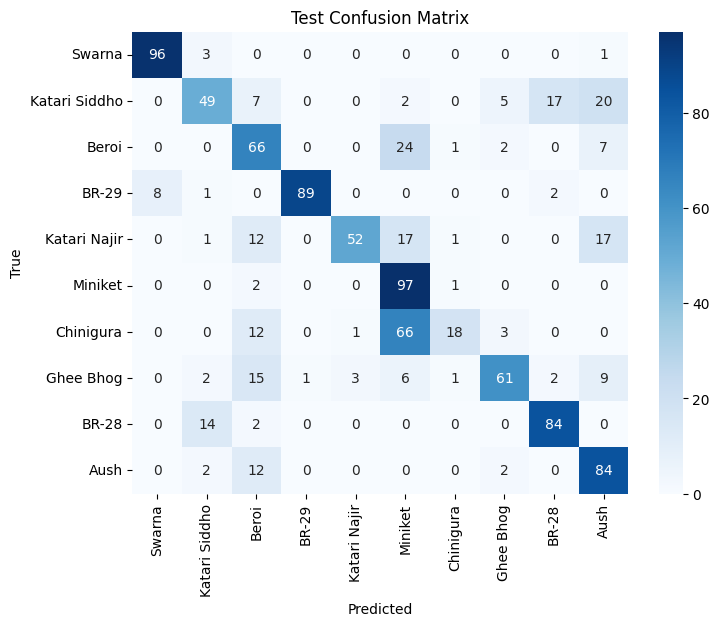

Swarna Accuracy: 0.9600
Katari Siddho Accuracy: 0.4900
Beroi Accuracy: 0.6600
BR-29 Accuracy: 0.8900
Katari Najir Accuracy: 0.5200
Miniket Accuracy: 0.9700
Chinigura Accuracy: 0.1800
Ghee Bhog Accuracy: 0.6100
BR-28 Accuracy: 0.8400
Aush Accuracy: 0.8400

Macro Precision: 0.7557
Macro Recall: 0.6960
Macro F1-score: 0.6841


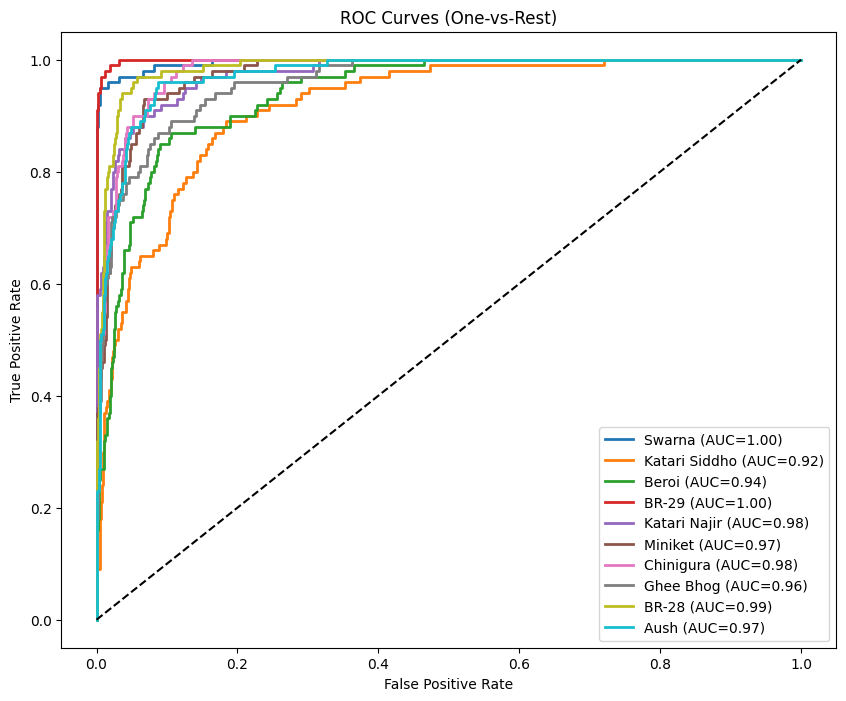

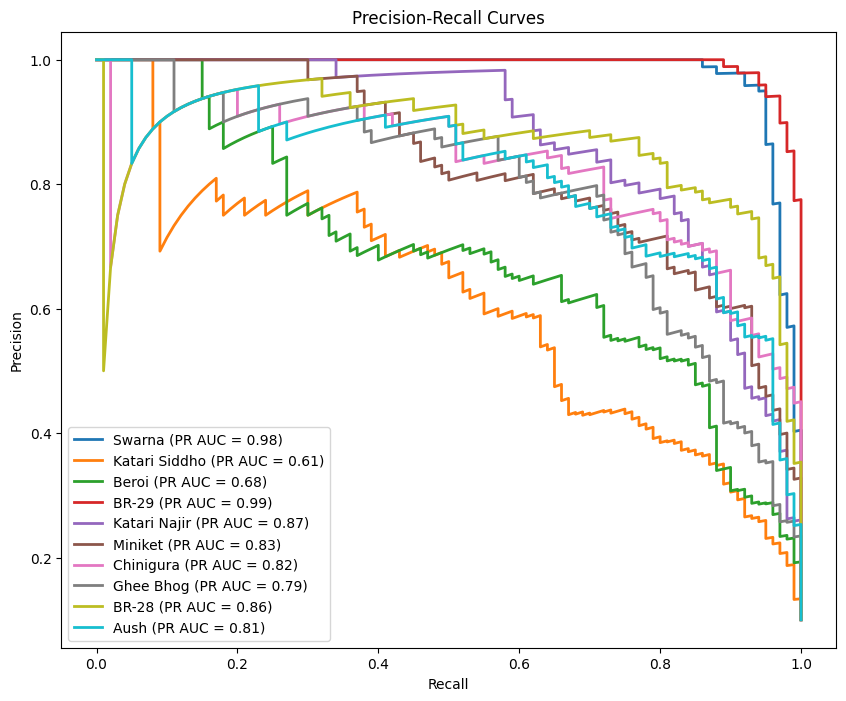


Most confused class pairs:
Swarna is most often confused with Katari Siddho (3 samples)
Katari Siddho is most often confused with Aush (20 samples)
Beroi is most often confused with Miniket (24 samples)
BR-29 is most often confused with Swarna (8 samples)
Katari Najir is most often confused with Miniket (17 samples)
Miniket is most often confused with Beroi (2 samples)
Chinigura is most often confused with Miniket (66 samples)
Ghee Bhog is most often confused with Beroi (15 samples)
BR-28 is most often confused with Katari Siddho (14 samples)
Aush is most often confused with Beroi (12 samples)


In [31]:
#Model-4: ResNet50
import os
import time
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data'
dataset_dir = "/kaggle/input/processed-rice-varieties-of-bangladesh/PRBD Microscopic Image of Different Processed Rice/Original_Images"
img_size = (224, 224)
batch_size = 16
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Build fine-tuned ResNet50 model
# -----------------------------
def build_resnet_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Fine-tune last 30 layers
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        layer.trainable = True
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

resnet_model = build_resnet_model(num_classes=num_classes)

# -----------------------------
# Compile model
# -----------------------------
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -----------------------------
# Callbacks
# -----------------------------
checkpoint = ModelCheckpoint('best_resnet50_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

start_time = time.time()

history = resnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[checkpoint, reduce_lr],
    verbose=2
)

training_time = time.time() - start_time
print(f"\nTotal Training Time: {training_time/60:.2f} minutes")

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true, y_pred_prob = [], []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, resnet_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# -----------------------------
# Metrics
# -----------------------------
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"\nMacro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# -----------------------------
# ROC–AUC Curves
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))
plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# PR Curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)
print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [34]:
# -----------------------------
# Inference time per sample
# -----------------------------
start_test = time.time()
_ = resnet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
print(f"Inference time per sample: {inference_time/test_gen.samples:.6f} sec")
print(f"Total inference time for {test_gen.samples} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Inference time per sample: 0.015014 sec
Total inference time for 1000 seconds


In [33]:
# -----------------------------
# Model parameters summary
# -----------------------------
total_params = resnet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in resnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in resnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 24,641,930
Trainable Parameters: 15,504,394
Non-Trainable Parameters: 9,137,536


Found 900 images belonging to 10 classes.
Found 100 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50
29/29 - 67s - 2s/step - accuracy: 0.4822 - loss: 1.6528 - val_accuracy: 0.7400 - val_loss: 0.7709 - learning_rate: 0.0010
Epoch 2/50
29/29 - 7s - 255ms/step - accuracy: 0.7556 - loss: 0.7480 - val_accuracy: 0.8600 - val_loss: 0.4936 - learning_rate: 0.0010
Epoch 3/50
29/29 - 7s - 254ms/step - accuracy: 0.7878 - loss: 0.6077 - val_accuracy: 0.8900 - val_loss: 0.4284 - learning_rate: 0.0010
Epoch 4/50
29/29 - 7s - 255ms/step - accuracy: 0.8256 - loss: 0.4969 - val_accuracy: 0.9000 - val_loss: 0.3596 - learning_rate: 0.0010
Epoch 5/50
29/29 - 7s - 256ms/step - accuracy: 0.8867 - loss: 0.3772 - val_accuracy: 0.8900 - val_loss: 0.3219 - learning_rate: 0.0010
Epoch 6/50
29/29 - 7s - 258ms/step - accuracy: 0.8811 - loss: 0.3664 - val_accuracy: 0.9000 - val_loss: 0.2953 - learning_rate: 0.0010
Epoch 7/50
29/

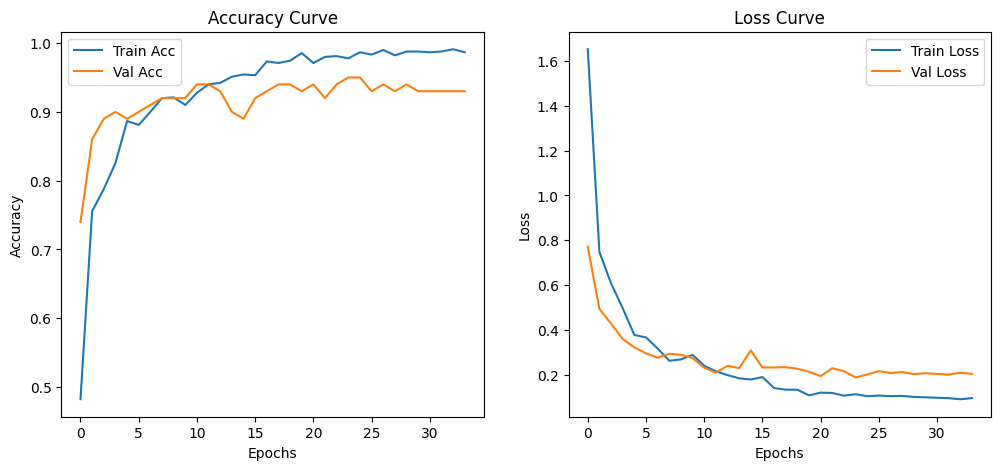


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.9899    0.9800    0.9849       100
Katari Siddho     0.8113    0.8600    0.8350       100
        Beroi     0.9149    0.8600    0.8866       100
        BR-29     0.9706    0.9900    0.9802       100
 Katari Najir     0.9899    0.9800    0.9849       100
      Miniket     0.9186    0.7900    0.8495       100
    Chinigura     0.7692    0.9000    0.8295       100
    Ghee Bhog     0.9100    0.9100    0.9100       100
        BR-28     0.9898    0.9700    0.9798       100
         Aush     0.9192    0.9100    0.9146       100

     accuracy                         0.9150      1000
    macro avg     0.9183    0.9150    0.9155      1000
 weighted avg     0.9183    0.9150    0.9155      1000



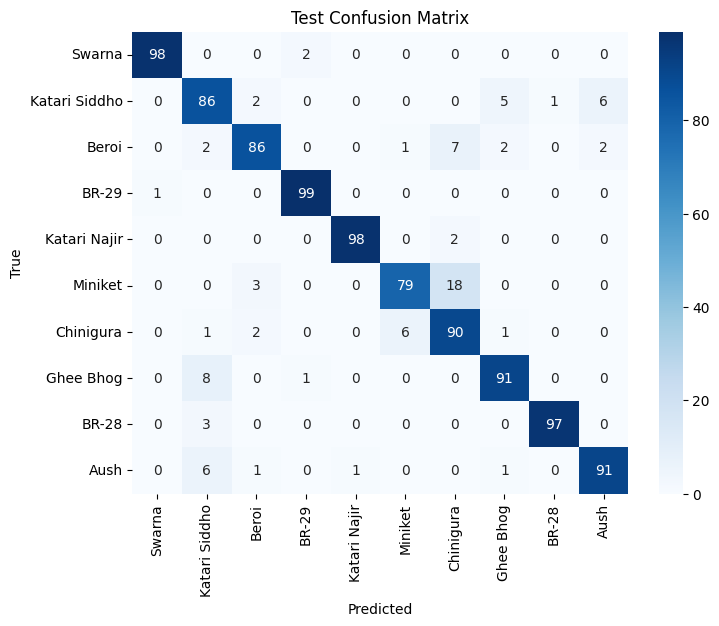

Swarna Accuracy: 0.9800
Katari Siddho Accuracy: 0.8600
Beroi Accuracy: 0.8600
BR-29 Accuracy: 0.9900
Katari Najir Accuracy: 0.9800
Miniket Accuracy: 0.7900
Chinigura Accuracy: 0.9000
Ghee Bhog Accuracy: 0.9100
BR-28 Accuracy: 0.9700
Aush Accuracy: 0.9100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Total inference time: 27.34 sec
Inference time per sample: 0.027338 sec


In [35]:
# Mode5: DenseNet121

import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data'
dataset_dir = "/kaggle/input/processed-rice-varieties-of-bangladesh/PRBD Microscopic Image of Different Processed Rice/Original_Images"
img_size = (224, 224)  # DenseNet121 default input
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators
# -----------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Model: DenseNet121
# -----------------------------
def build_densenet_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

densenet_model = build_densenet_model(num_classes=num_classes)
densenet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# Callbacks
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # increased patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training
# -----------------------------
start_time = time.time()
history = densenet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,  # increased epochs
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
training_time = time.time() - start_time
print(f"Total training time: {training_time:.2f} sec")

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, densenet_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, densenet_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, densenet_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# -----------------------------
# Testing / Inference time per sample
# -----------------------------
start_infer = time.time()
_ = densenet_model.predict(test_gen, verbose=0)
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")


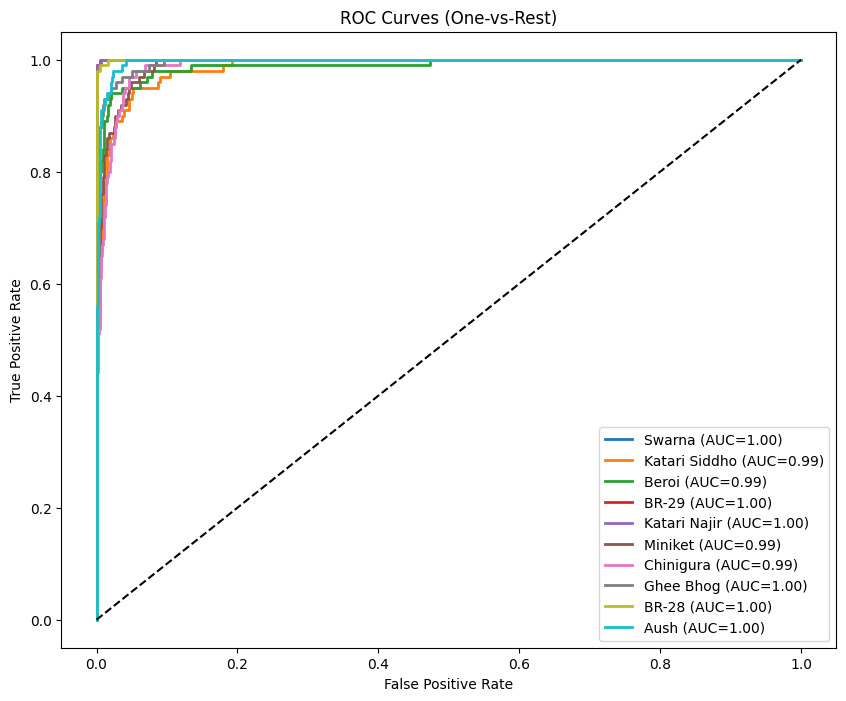

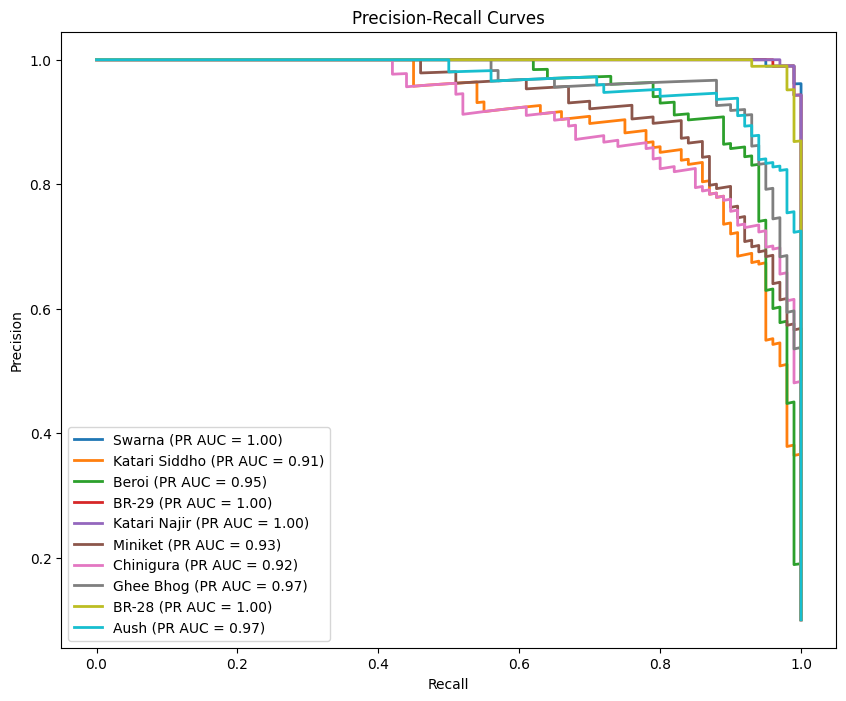


Most confused class pairs:
Swarna is most often confused with BR-29 (2 samples)
Katari Siddho is most often confused with Aush (6 samples)
Beroi is most often confused with Chinigura (7 samples)
BR-29 is most often confused with Swarna (1 samples)
Katari Najir is most often confused with Chinigura (2 samples)
Miniket is most often confused with Chinigura (18 samples)
Chinigura is most often confused with Miniket (6 samples)
Ghee Bhog is most often confused with Katari Siddho (8 samples)
BR-28 is most often confused with Katari Siddho (3 samples)
Aush is most often confused with Katari Siddho (6 samples)

Total Training Time: 310.06 sec


In [36]:
 #ROC–AUC curves

y_true_bin = label_binarize(test_true, classes=range(num_classes))
plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# Precision–Recall curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")

print(f"\nTotal Training Time: {training_time:.2f} sec")

In [37]:
# -----------------------------
# Inference time per sample
# -----------------------------
start_test = time.time()
_ = densenet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")


Inference Time per sample: 0.007601 seconds


In [38]:
# -----------------------------
# Calculate and print model parameters
# -----------------------------
total_params = densenet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in densenet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in densenet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 7,567,434
Trainable Parameters: 529,930
Non-Trainable Parameters: 7,037,504
